In [2]:
import json
import numpy as np
import re
from BT import *
from eigentrust import *

In [2]:
data_path = '20250513_224000'
data = []
filepath = f'transcript/{data_path}/evaluations_cleaned.json'
with open(filepath, 'r') as file:
    data.extend(json.load(file))
comparisons=[]
for i, item in enumerate(data):
    response = item['judge response']
    eval1_response = item['eval1 response']
    eval2_response = item['eval2 response']

    if "Error in " in response or "Error in " in eval1_response or "Error in " in eval2_response:
        print(f"Error in {i}th API call")
        continue
    m = re.search(r'<choice>(.)</choice>', response)
    if m:
        score = int(m.group(1))
        comparisons.append([item['judge'], item['eval1'], item['eval2'], score])
    else:
        print(f"No <choice>…</choice> match found in the {i}th judge response")

func = {'(0, 0)': 0,
        '(0, 1)': 1,
        '(0, 2)': 2,
        '(0, 3)': 3,
        '(0, 4)': 4,
        '(1, 0)': 5,
        '(1, 1)': 6,
        '(1, 2)': 7,
        '(1, 3)': 8,
        '(1, 4)': 9,
        '(2, 0)': 10,
        '(2, 1)': 11,
        '(2, 2)': 12,
        '(2, 3)': 13,
        '(2, 4)': 14,
        '(3, 0)': 15,
        '(3, 1)': 16,
        '(3, 2)': 17,
        '(3, 3)': 18,
        '(3, 4)': 19,
        '(4, 0)': 20,
        '(4, 1)': 21,
        '(4, 2)': 22,
        '(4, 3)': 23,
        '(4, 4)': 24,}


In [3]:
mapped_comparisons = []
for item in comparisons:
    l = [func[x] for x in item[:3]]
    l.append(item[3])
    mapped_comparisons.append(l)


In [4]:
from sklearn.model_selection import train_test_split
train_comps, test_comps = train_test_split(
    mapped_comparisons,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
train_loader = DataLoader(PairwiseDataset(train_comps), batch_size=32, shuffle=True)
test_loader  = DataLoader(PairwiseDataset(test_comps),  batch_size=32, shuffle=False)


In [ ]:
num_models = 25
d = 1

lr = 1e-4
weight_decay = 0
max_epochs = 200

model = VectorBT(num_models, d)

print('Now training')
loss_history = train_vector_bt(
    model, 
    train_loader,
    lr=lr, 
    weight_decay=weight_decay,
    max_epochs=max_epochs, 
    device='mps',
)

avg_train_loss = loss_history[-1]
print(f"Final average TRAIN loss = {avg_train_loss:.4f}")

Now training
Epoch  10, Loss = 0.6844
Epoch  20, Loss = 0.6402
Epoch  30, Loss = 0.5978
Epoch  40, Loss = 0.5761


KeyboardInterrupt: 

In [47]:
test_losses=[]
train_losses=[]
for n in range(1,30):
    filepath = f'figures/dimensionality/models_mn_by_d/'
    with open(filepath+f'loss_history_{n}.json', 'r') as file:
        loss_history = json.load(file)

    model_path = filepath+f'model__{n}.pth'
    num_models=25
    d=n
    device='mps'
    
    model = load_vector_bt(model_path, num_models, d, device)

    print(f'Now testing on holdout set for n={n}')

    model.eval()
    loss_fn = nn.BCELoss()
    total_test_loss = 0.0

    with torch.no_grad():
        for i_idx, j_idx, k_idx, r in test_loader:
            i_idx, j_idx, k_idx = i_idx.to(device), j_idx.to(device), k_idx.to(device)
            r = (2 - r.to(device))             # {1,2}→{1,0}
            preds = model(i_idx, j_idx, k_idx)
            loss  = loss_fn(preds, r)
            total_test_loss += loss.item() * r.size(0)

    avg_test_loss = total_test_loss / len(test_loader.dataset)
    print(f"Test  BCE Loss = {avg_test_loss:.4f}")

    test_losses.append([n, avg_test_loss])
    train_losses.append([n, min(loss_history)])

Now testing on holdout set for n=1
Test  BCE Loss = 0.5626
Now testing on holdout set for n=2
Test  BCE Loss = 0.5472
Now testing on holdout set for n=3
Test  BCE Loss = 0.5415
Now testing on holdout set for n=4
Test  BCE Loss = 0.5419
Now testing on holdout set for n=5
Test  BCE Loss = 0.5431
Now testing on holdout set for n=6
Test  BCE Loss = 0.5445
Now testing on holdout set for n=7
Test  BCE Loss = 0.5486
Now testing on holdout set for n=8
Test  BCE Loss = 0.5496
Now testing on holdout set for n=9
Test  BCE Loss = 0.5495
Now testing on holdout set for n=10
Test  BCE Loss = 0.5510
Now testing on holdout set for n=11
Test  BCE Loss = 0.5522
Now testing on holdout set for n=12
Test  BCE Loss = 0.5525
Now testing on holdout set for n=13
Test  BCE Loss = 0.5537
Now testing on holdout set for n=14
Test  BCE Loss = 0.5543
Now testing on holdout set for n=15
Test  BCE Loss = 0.5549
Now testing on holdout set for n=16
Test  BCE Loss = 0.5558
Now testing on holdout set for n=17
Test  BCE Los

In [ ]:
filepath = f'figures/dimensionality/models_mn_by_d/'
with open(filepath+f'train_losses.json', 'w') as file:
    json.dump(train_losses, file, indent=4)
with open(filepath+f'test_losses.json', 'w') as file:
    json.dump(test_losses,file,indent=4)

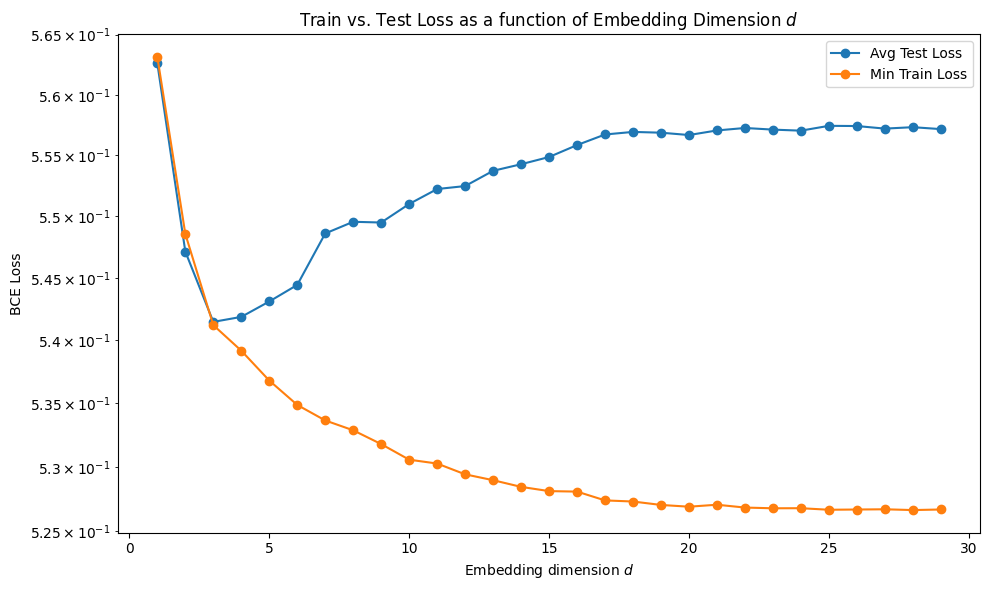

In [57]:
ns_test, test_vals  = zip(*test_losses)
ns_train, train_vals = zip(*train_losses)

plt.figure(figsize=(10,6))
# plot test loss
plt.plot(ns_test, test_vals,
         marker='o', 
         label='Avg Test Loss')
# plot train loss
plt.plot(ns_train, train_vals,
         marker='o', 
         label='Min Train Loss')

plt.xlabel(r'Embedding dimension $d$')
plt.ylabel('BCE Loss')
plt.title(r'Train vs. Test Loss as a function of Embedding Dimension $d$')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig('figures/dimensionality/models_mn_by_d/plot_log.png', dpi=300)
plt.show()

## Checking if n=25 is orthogonal

In [42]:
filepath = f'figures/dimensionality/models_mn_by_d/'
model_path = filepath+f'model__25.pth'
loss_history_path = filepath+'loss_history_25.json'
num_models=25
d=25
device='mps'

model = load_vector_bt(model_path, num_models, d, device)
with open(loss_history_path, 'r') as file:
    loss_history = json.load(file)

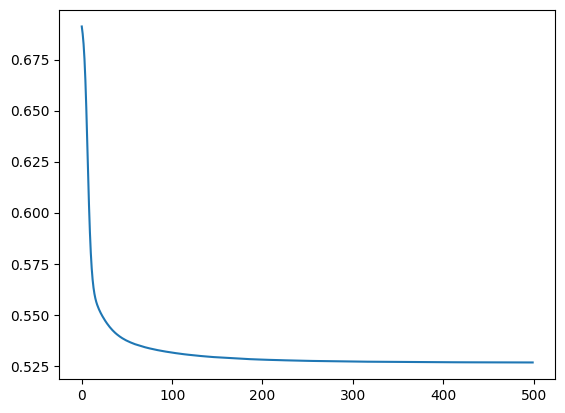

In [43]:
plt.plot(loss_history)
plt.show()

In [44]:
u_weights = model.u.weight.detach().cpu().numpy()
v_weights = model.v.weight.detach().cpu().numpy()

In [45]:
U_dot = np.zeros((25,25))
for i, u in enumerate(u_weights):
    for j, u_ in enumerate(u_weights):
        U_dot[i,j] = np.dot(u,u_)

In [46]:
np.diagonal(U_dot)

array([2.59635234, 1.82307744, 4.26702976, 2.01703835, 2.05235124,
       3.82034445, 3.50831056, 3.45357895, 2.84471035, 2.67349839,
       2.97431755, 2.57384157, 5.07617712, 3.32679391, 3.35312557,
       1.51384532, 1.78264606, 1.7002635 , 1.4537499 , 1.45870757,
       2.82785535, 1.83218586, 2.3016324 , 3.28657794, 2.11030746])

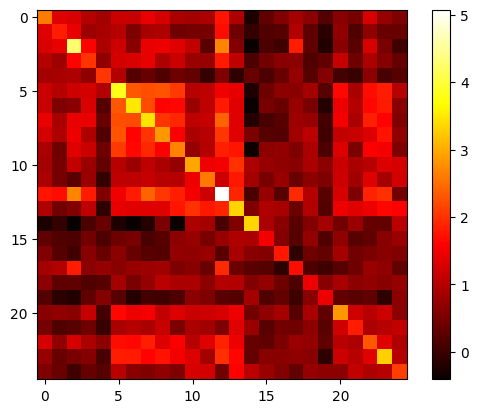

In [47]:
plt.imshow(U_dot, cmap='hot', interpolation='nearest')
plt.colorbar()

In [10]:
for i in range(25):
    print(i, np.argmax(U_dot[i]))

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 12
18 18
19 19
20 20
21 21
22 22
23 23
24 24


### Now let's compare with n=3

In [48]:
filepath = f'figures/dimensionality/models_mn_by_d/'
model_path = filepath+f'model__3.pth'
loss_history_path = filepath+'loss_history_3.json'
num_models=25
d=3
device='mps'

model = load_vector_bt(model_path, num_models, d, device)
with open(loss_history_path, 'r') as file:
    loss_history = json.load(file)

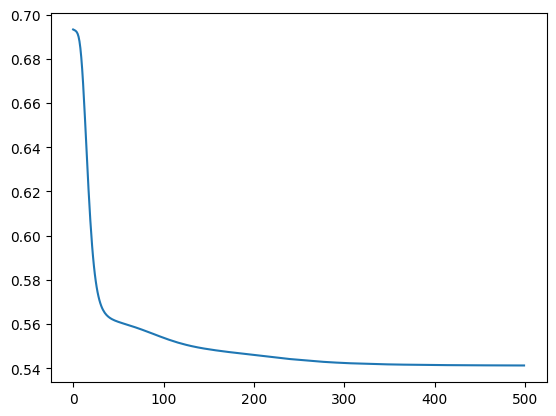

In [49]:
plt.plot(loss_history)
plt.show()

In [50]:
u_weights = model.u.weight.detach().cpu().numpy()
v_weights = model.v.weight.detach().cpu().numpy()

In [51]:
U_dot = np.zeros((25,25))
for i, u in enumerate(u_weights):
    for j, u_ in enumerate(u_weights):
        U_dot[i,j] = np.dot(u,u_)

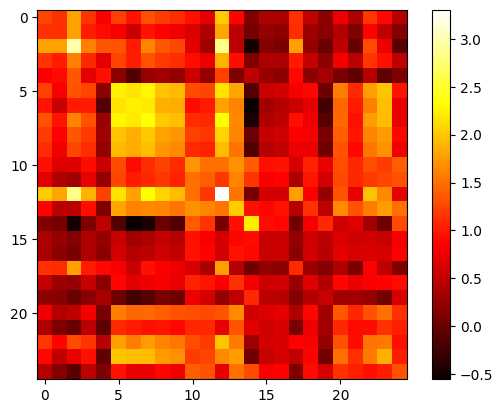

In [52]:
plt.imshow(U_dot, cmap='hot', interpolation='nearest')
plt.colorbar()

In [38]:
np.diagonal(U_dot)

array([1.25924933, 1.13391507, 2.98010778, 1.07991409, 0.94638759,
       2.24290419, 2.23420978, 2.35434651, 1.79148936, 1.65432394,
       1.71100211, 1.39665985, 3.30346084, 2.03392386, 2.22452402,
       0.54627174, 0.56482619, 1.09418678, 0.67699981, 0.54452229,
       1.35391688, 0.91854268, 1.5208869 , 1.85783219, 1.31924438])

In [39]:
for i in range(25):
    print(i, np.argmax(U_dot[i]))

0 12
1 12
2 2
3 12
4 2
5 7
6 6
7 7
8 12
9 7
10 10
11 13
12 12
13 13
14 14
15 10
16 13
17 12
18 13
19 14
20 13
21 13
22 12
23 5
24 13


## New plot 8/4

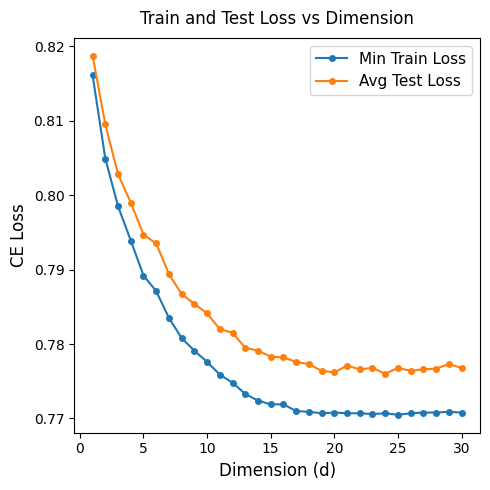

In [8]:
# Training and Test Loss Data for dimensions d=1 to 25

# Dimensions (x-axis)
dimensions = list(range(1, 31))

# Training losses (minimum train loss for each dimension)
train_losses = [
    0.8161, 0.8049, 0.7985, 0.7939, 0.7892,
    0.7871, 0.7835, 0.7808, 0.7791, 0.7776,
    0.7759, 0.7748, 0.7733, 0.7724, 0.7719,
    0.7719, 0.7710, 0.7709, 0.7707, 0.7708,
    0.7707, 0.7707, 0.7706, 0.7707, 0.7705,
    0.7707, 0.7708, 0.7708, 0.7709, 0.7708
]

# Test losses
test_losses = [
    0.8187, 0.8095, 0.8028, 0.7990, 0.7947,
    0.7935, 0.7894, 0.7867, 0.7854, 0.7841,
    0.7820, 0.7815, 0.7795, 0.7791, 0.7783,
    0.7782, 0.7776, 0.7773, 0.7764, 0.7762,
    0.7771, 0.7766, 0.7768, 0.7760, 0.7768,
    0.7764, 0.7766, 0.7767, 0.7773, 0.7768
]

# Example plotting code using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(dimensions, train_losses, label='Min Train Loss', marker='o', markersize=4)
plt.plot(dimensions, test_losses, label='Avg Test Loss', marker='o', markersize=4)
plt.xlabel('Dimension (d)', fontsize=12)
plt.ylabel('CE Loss', fontsize=12)
plt.title('Train and Test Loss vs Dimension', fontsize=12, pad=10)
plt.legend(fontsize=11)
# plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figure.png', dpi=500)
plt.show()

## plot of 7/31 airisk kindness 5 models

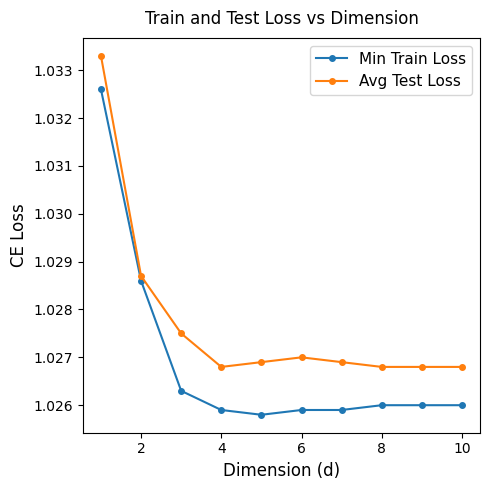

In [11]:
# Training and Test Loss Data for dimensions d=1 to 25

# Dimensions (x-axis)
dimensions = list(range(1,11))

# Training losses (minimum train loss for each dimension)
train_losses = [
    1.0326, 1.0286, 1.0263, 1.0259, 1.0258, 
    1.0259, 1.0259, 1.0260, 1.0260, 1.0260, 
]

# train_losses = [
#     1.0444, 1.0404, 1.0385, 1.0379, 1.0377,
#     1.0378, 1.0378, 1.0378, 1.0378, 1.0378
# ]

# Test losses
test_losses = [
    1.0333, 1.0287, 1.0275, 1.0268, 1.0269, 
    1.0270, 1.0269, 1.0268, 1.0268, 1.0268
]
# test_losses = [
#     1.0427, 1.0388, 1.0362, 1.0357, 1.0358,
#     1.0358, 1.0360, 1.0357, 1.0360, 1.0357
# ]

# Example plotting code using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(dimensions, train_losses, label='Min Train Loss', marker='o', markersize=4)
plt.plot(dimensions, test_losses, label='Avg Test Loss', marker='o', markersize=4)
plt.xlabel('Dimension (d)', fontsize=12)
plt.ylabel('CE Loss', fontsize=12)
plt.title('Train and Test Loss vs Dimension', fontsize=12, pad=10)
plt.legend(fontsize=11)
# plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('figure.png', dpi=500)
plt.show()

## 11/23 plot

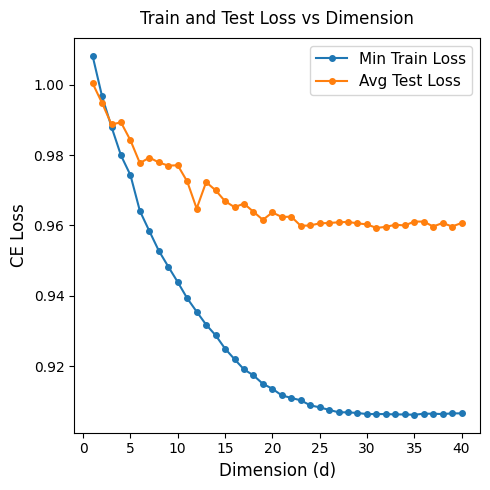

In [8]:
import re
import os

dims = range(1,41)

# Base path
base_path = "transcript/20251119_000000/btd runs (new test loss)"

# Store results in lists
train_losses = []
test_losses = []

for d in dims:
    folder_name = f"btd_d{d}"
    log_path = os.path.join(base_path, folder_name, "log_train.txt")
    
    if os.path.exists(log_path):
        with open(log_path, 'r') as f:
            content = f.read()
            
            # Extract Min Train Loss
            train_match = re.search(r'Min Train Loss = ([\d.]+)', content)
            # Extract Test Loss (first occurrence)
            test_match = re.search(r'Test Loss = ([\d.]+)', content)
            
            if train_match and test_match:
                train_loss = float(train_match.group(1))
                test_loss = float(test_match.group(1))
                train_losses.append(train_loss)
                test_losses.append(test_loss)
            else:
                print(f"d={d}: Could not find loss values")
                train_losses.append(None)
                test_losses.append(None)
    else:
        print(f"d={d}: File not found at {log_path}")
        train_losses.append(None)
        test_losses.append(None)

dimensions = list(dims)

# Example plotting code using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(dimensions, train_losses, label='Min Train Loss', marker='o', markersize=4)
plt.plot(dimensions, test_losses, label='Avg Test Loss', marker='o', markersize=4)
plt.xlabel('Dimension (d)', fontsize=12)
plt.ylabel('CE Loss', fontsize=12)
plt.title('Train and Test Loss vs Dimension', fontsize=12, pad=10)
plt.legend(fontsize=11)
# plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('figure.png', dpi=500)
plt.show()